In [1]:
import itertools
import os
import sys
import glob
import time
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns; sns.set(color_codes=True)
from pandas import DataFrame
from sklearn import mixture
from scipy import linalg
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

try:
    import sqlite3
except ImportError:
    print 'you need sqlite3 installed to use this program'
    sys.exit(0)
    
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/pandas/core/computation/__init__.py:18: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


In [2]:
def encode_string(s):
    """
    Simple utility function to make sure a string is proper
    to be used in a SQLite query
    (different than posgtresql, no N to specify unicode)
    EXAMPLE:
      That's my boy! -> 'That''s my boy!'
    """
    return "'"+s.replace("'","''")+"'"

In [3]:
# PATH TO track_metadat.db
# CHANGE THIS TO YOUR LOCAL CONFIGURATION
# IT SHOULD BE IN THE ADDITIONAL FILES
# (you can use 'subset_track_metadata.db')
dbfile = '/home/michael/Barista/Music/MillionSongSubset/AdditionalFiles/subset_track_metadata.db'

In [4]:
# connect to the SQLite database
conn = sqlite3.connect(dbfile)

# from that connection, get a cursor to do queries
c = conn.cursor()

# so there is no confusion, the table name is 'songs'
TABLENAME = 'songs'

In [6]:
# list all columns names from table 'songs'
q = "SELECT sql FROM sqlite_master WHERE tbl_name = 'songs' AND type = 'table'"
res = c.execute(q)
print '* get info on columns names (original table creation command):'
print res.fetchall()[0][0]

* get info on columns names (original table creation command):
CREATE TABLE songs (track_id text PRIMARY KEY, title text, song_id text, release text, artist_id text, artist_mbid text, artist_name text, duration real, artist_familiarity real, artist_hotttnesss real, year int)


In [8]:
# query for all the familiarities
q = "SELECT artist_familiarity FROM songs GROUP by artist_id"
res = c.execute(q)
familiarities = res.fetchall() # does the actual job of searching the db
print '* found',len(familiarities),'Familiarities, response looks like:'
print (familiarities)[:5]

* found 3888 Familiarities, response looks like:
[(0.39681784431,), (0.514064276419,), (0.471212607351,), (0.588571842057,), (0.634764556371,)]


In [9]:
# query for all the hotttness's
q = "SELECT artist_hotttnesss FROM songs GROUP by artist_id"
res = c.execute(q)
hotttnesss = res.fetchall() # does the actual job of searching the db
print '* found',len(hotttnesss),'Hotttnesss, response looks like:'
print (hotttnesss)[:5]

* found 3888 Hotttnesss, response looks like:
[(0.297404802871,), (0.395627514317,), (0.340275507301,), (0.360644227016,), (0.423976263499,)]


In [10]:
# close the cursor and the connection
# (if for some reason you added stuff to the db or alter
#  a table, you need to also do a conn.commit())
c.close()
conn.close()

In [11]:
# Remove entries that have no familiarity or no hotttnesss rating (0.0)

familiarities=np.array(familiarities)
hotttnesss=np.array(hotttnesss)
no_fam_value_ind=np.where(familiarities==[0.0])
no_hot_value_ind=np.where(hotttnesss==[0.0])
Out=np.concatenate((no_fam_value_ind,no_hot_value_ind),axis=1)
Out=Out[0]
familiarities=np.delete(familiarities,Out)
hotttnesss=np.delete(hotttnesss,Out)

In [12]:
# Create single array of the data
X=np.r_['1,2,0', familiarities, hotttnesss]

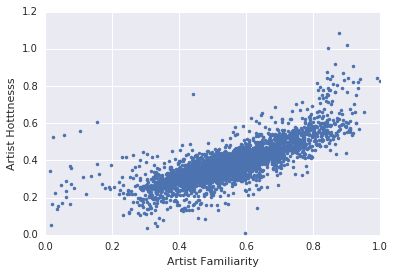

In [56]:
##### Plot Data #####
#####################

plt.plot(familiarities,hotttnesss,'b.')
plt.xlim(0.0,1.0)
plt.xlabel('Artist Familiarity')
plt.ylabel('Artist Hotttnesss')
plt.show()

In [67]:
##### GMM ######
################

color_iter = itertools.cycle(['navy', 'c', 'green',
                              'darkorange'])

def plot_results(X, Y_, means, covariances, index, title):
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)
    
    plt.xlim(0.0, 1.0)
    plt.ylim(0.0, 1.0)
    plt.xticks(())
    plt.yticks(())
    plt.xlabel('Artist Familiarity')
    plt.ylabel('Artist Hotttnesss')
    plt.title(title)

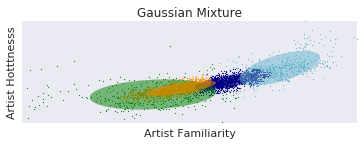

In [68]:
# Fit a Gaussian mixture with EM
gmm = mixture.GaussianMixture(n_components=4, covariance_type='full').fit(X)
plot_results(X, gmm.predict(X), gmm.means_, gmm.covariances_, 0,
             'Gaussian Mixture')

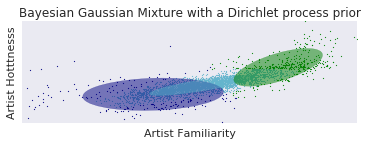

In [69]:
# Fit a Dirichlet process Gaussian mixture
dpgmm = mixture.BayesianGaussianMixture(n_components=3,
                                        covariance_type='full').fit(X)
plot_results(X, dpgmm.predict(X), dpgmm.means_, dpgmm.covariances_, 1,
             'Bayesian Gaussian Mixture with a Dirichlet process prior')

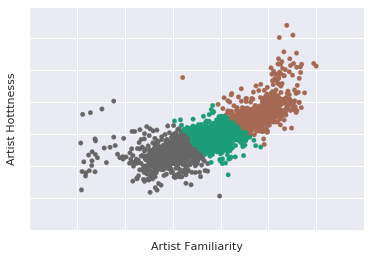

In [90]:
##### K-means #####
###################

est=KMeans(n_clusters=3)
name='k_means_3'

fignum = 1

fig,ax = plt.subplots()
est.fit(X)
labels = est.labels_

ax.scatter(X[:, 0], X[:, 1], c=labels.astype(np.float), cmap='Dark2',edgecolors='face')

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.set_xlabel('Artist Familiarity')
ax.set_ylabel('Artist Hotttnesss')
fignum = fignum + 1
    
plt.show()

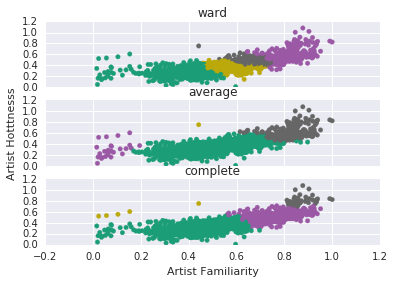

In [96]:
##### Agglomerative #####
#########################

linkages=['ward','average','complete']
i=1

for link in linkages:
    agl = AgglomerativeClustering(n_clusters=4,affinity='euclidean',linkage=link)
    y_pred = agl.fit_predict(X)

    plt.subplot(3,1,i)
    plt.scatter(X[:,0],X[:,1],c=y_pred,cmap='Dark2',edgecolors='face')
    plt.title(link)
    plt.ylim(0.0,1.2)
    if i==3:
        plt.xlabel('Artist Familiarity')
        plt.yticks()
    else:
        plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    if i==2:
        plt.ylabel('Artist Hotttnesss') 
    i=i+1

plt.show()

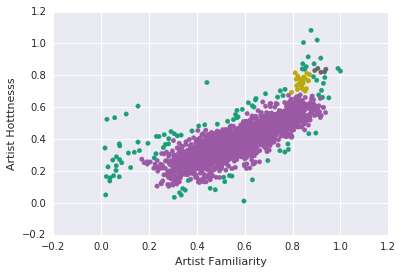

In [99]:
##### DBScan #####
#########################

dbs = DBSCAN(eps=0.03,min_samples=5)
y_pred = dbs.fit_predict(X)

plt.figure()
plt.scatter(X[:,0],X[:,1],c=y_pred,cmap='Dark2',edgecolors='face')
plt.xlabel('Artist Familiarity')
plt.ylabel('Artist Hotttnesss')
plt.show()

In [14]:
agl = AgglomerativeClustering(n_clusters=4,affinity='euclidean',linkage='average')
y_pred = agl.fit_predict(X)

In [15]:
d={'familiarities': familiarities, 'hotttnesss': hotttnesss, 'cluster': y_pred}
df = DataFrame(data=d)

In [16]:
cluster0=df.loc[df['cluster'] == 0]
cluster_other=df.loc[df['cluster'] != 0]

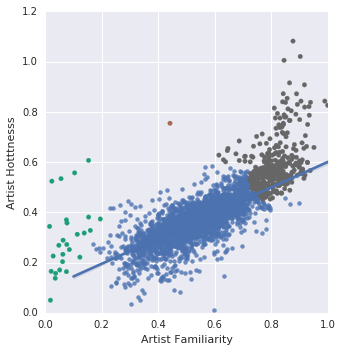

In [101]:
sns.lmplot(x="familiarities", y="hotttnesss", hue="cluster", data=cluster0, legend=False)
plt.scatter(cluster_other['familiarities'],cluster_other['hotttnesss'],c=cluster_other['cluster'],cmap='Dark2',edgecolors='face')
plt.xlim(0.0,1.0)
plt.ylim(0.0,1.2)
plt.xlabel('Artist Familiarity')
plt.ylabel('Artist Hotttnesss')

(0.0, 1.0)

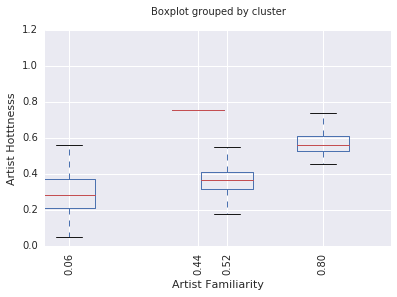

In [104]:
### Box Plots ###

med0=np.median((df.loc[df['cluster'] == 0])['familiarities'])
med1=np.median((df.loc[df['cluster'] == 1])['familiarities'])
med2=np.median((df.loc[df['cluster'] == 2])['familiarities'])
med3=np.median((df.loc[df['cluster'] == 3])['familiarities'])

DataFrame.boxplot(df,column='hotttnesss',by='cluster',positions=[med0,med1,med2,med3])
plt.xlabel('Artist Familiarity')
plt.ylabel('Artist Hotttnesss')
plt.title('')
plt.xticks([med0,med1,med2,med3],[str(med0)[0:4],str(med1)[0:4],str(med2)[0:4],str(med3)[0:4]],rotation='vertical')
plt.xlim(0.0,1.0)